In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [2]:
def load_data(data_dir, cache_on=True):
    def read_image(filename):
        label = int(filename[filename.rindex('_') + 1])
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        return img, label
    
    def read_images(img_dir):
        cache = os.path.join(img_dir, 'data.npz')
        if cache_on and os.path.exists(cache):
            with open(cache, 'rb') as f:
                data = np.load(f)
                return data['arr_0'], data['arr_1']

        X, y = [], []
        for filename in os.listdir(img_dir):
            if os.path.splitext(filename)[1] != '.png':
                continue
            img, label = read_image(os.path.join(img_dir, filename))
            X.append(img)
            y.append(label)

        X = np.array(X)
        y = np.array(y)
        
        X = X.reshape(*X.shape, 1).astype(np.float16)
        
        if cache_on:
            np.savez(cache, X, y)

        return X, y
    
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    return read_images(train_dir), read_images(test_dir)

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = load_data('images_reduced')

In [6]:
Xtrain.shape, Xtrain.dtype, ytrain.shape, ytrain.dtype

((3000, 128, 128, 1), dtype('float16'), (3000,), dtype('int64'))

In [7]:
Xtest.shape, Xtest.dtype, ytest.shape, ytest.dtype

((600, 128, 128, 1), dtype('float16'), (600,), dtype('int64'))

In [ ]:
X, y = Xtrain, ytrain
Xreduced = np.empty((0, *X.shape[1:]), dtype=X.dtype)
yreduced = np.empty((0, *y.shape[1:]), dtype=y.dtype)
m = 100
for i in range(6):
    x = X[y == i]
    yreduced = np.append(yreduced, np.full(m, i))
    Xreduced = np.append(Xreduced, x[np.random.choice(len(x), m, replace=False)], axis=0)

In [ ]:
np.savez('images_reduced/test/data.npz', Xreduced, yreduced)

In [8]:
Counter(ytrain), Counter(ytest)

(Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500}),
 Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}))

In [9]:
model = keras.Sequential([
    keras.layers.Conv2D(6, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='softmax'),
])

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=2)

Epoch 1/2
94/94 [==============================] - 6s 62ms/step - loss: 213.1871 - accuracy: 0.7167 - val_loss: 0.9677 - val_accuracy: 0.9833
Epoch 2/2
94/94 [==============================] - 5s 54ms/step - loss: 0.3097 - accuracy: 0.9857 - val_loss: 0.2682 - val_accuracy: 0.9933


In [12]:
df = pd.DataFrame(history.history)

<AxesSubplot:>

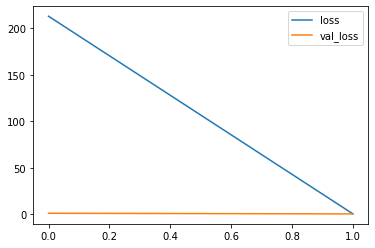

In [13]:
df[['loss', 'val_loss']].plot()

In [14]:
model.predict(np.expand_dims(Xtest[5], axis=0)).argmax()

0

In [15]:
model.save(os.path.join('models', 'dummy-model'))

INFO:tensorflow:Assets written to: models/dummy-model/assets


In [ ]:
loaded = keras.models.load_model(os.path.join('models', 'dummy-model'))

In [ ]:
n = 5
loaded.predict(np.expand_dims(Xtest[n], axis=0)).argmax(), ytest[n]

In [ ]:
source = cv2.VideoCapture('http://192.168.1.139:8080/video')
_, frame = source.read()
plt.imshow(frame)
source.release()

In [ ]:
frame.shape

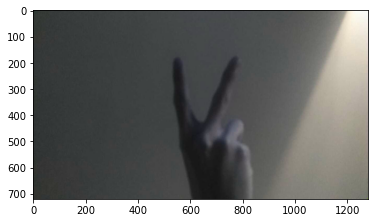

In [16]:
frame = cv2.imread('test.png', 1)
plt.imshow(frame)

In [ ]:
cv2.imwrite('test.png', frame)

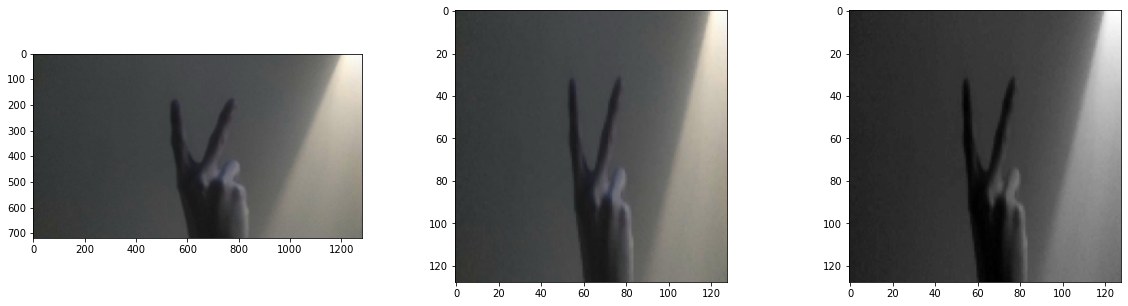

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(frame)

rframe = cv2.resize(frame, (128, 128))
plt.subplot(1, 3, 2)
plt.imshow(rframe)

plt.subplot(1, 3, 3)
rgframe = cv2.cvtColor(rframe, cv2.COLOR_BGR2GRAY)
plt.imshow(rgframe, cmap='gray')

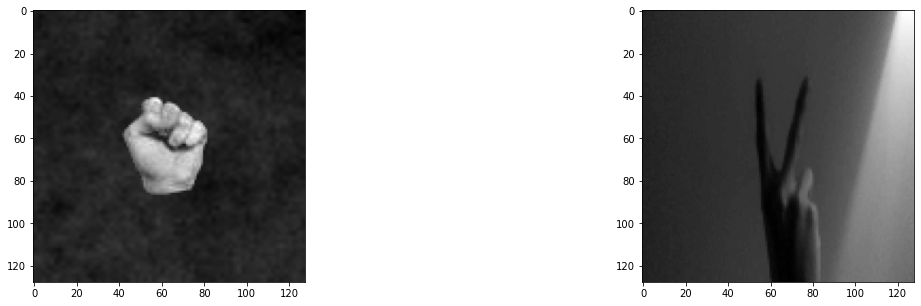

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(Xtrain[2].astype(np.int32), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rgframe, cmap='gray')

In [20]:
model.predict(np.expand_dims(rgframe.reshape(*rgframe.shape, 1), axis=0))

array([[1.0000000e+00, 2.6169078e-24, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)